In [1]:
# !pip install opencv-python transformers accelerate insightface
import diffusers
from diffusers.utils import load_image
from diffusers.models import ControlNetModel

import cv2
import torch
import numpy as np
from PIL import Image

from insightface.app import FaceAnalysis
from pipeline_stable_diffusion_xl_instantid import StableDiffusionXLInstantIDPipeline, draw_kps

# prepare 'antelopev2' under ./models
app = FaceAnalysis(name='antelopev2', root='./', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# prepare models under ./checkpoints
face_adapter = f'./checkpoints/ip-adapter.bin'
controlnet_path = f'./checkpoints/ControlNetModel'
controlnet_pose_model = "thibaud/controlnet-openpose-sdxl-1.0"
controlnet_canny_model = "diffusers/controlnet-canny-sdxl-1.0"

# load ControlNets
controlnet_identity = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)
controlnet_pose = ControlNetModel.from_pretrained(controlnet_pose_model, torch_dtype=torch.float16)
controlnet_canny = ControlNetModel.from_pretrained(controlnet_canny_model, torch_dtype=torch.float16)

base_model = 'cagliostrolab/animagine-xl-3.1'  # from https://civitai.com/models/84040?modelVersionId=196039
pipe = StableDiffusionXLInstantIDPipeline.from_pretrained(
    base_model,
    controlnet=[controlnet_identity, controlnet_pose, controlnet_canny],
    torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload()
pipe.enable_vae_tiling()
# pipe.cuda()

# load adapter
pipe.load_ip_adapter_instantid(face_adapter)

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
from controlnet_aux import OpenposeDetector
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

def get_canny_image(image, t1=100, t2=200):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    edges = cv2.Canny(image, t1, t2)
    return Image.fromarray(edges, "L")

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


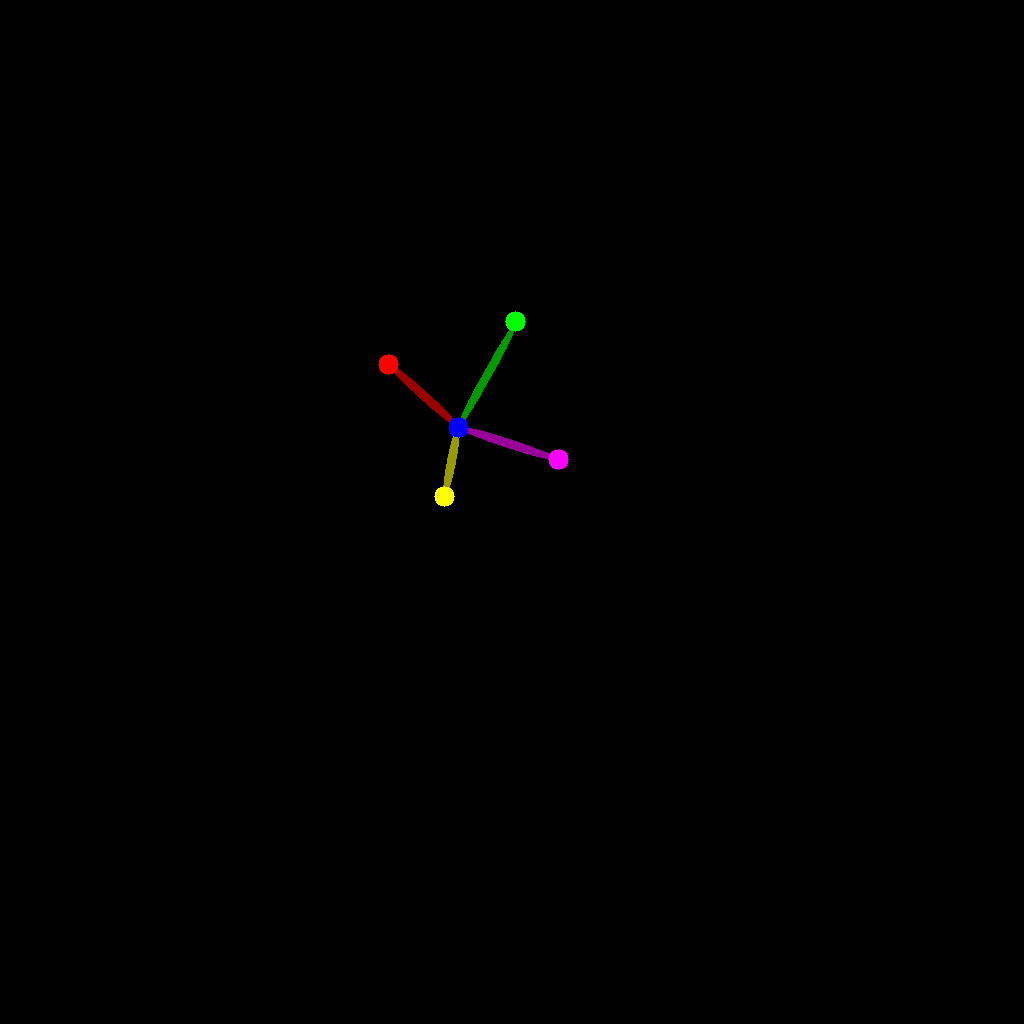

In [3]:
# load an image
face_image = load_image("./examples/musk_resize.jpeg").resize((1024, 1024))

# prepare face emb
face_info = app.get(cv2.cvtColor(np.array(face_image), cv2.COLOR_RGB2BGR))
face_info = sorted(face_info, key=lambda x:(x['bbox'][2]-x['bbox'][0])*(x['bbox'][3]-x['bbox'][1]))[-1]  # only use the maximum face
face_emb = face_info['embedding']
face_kps = draw_kps(face_image, face_info['kps'])
face_kps

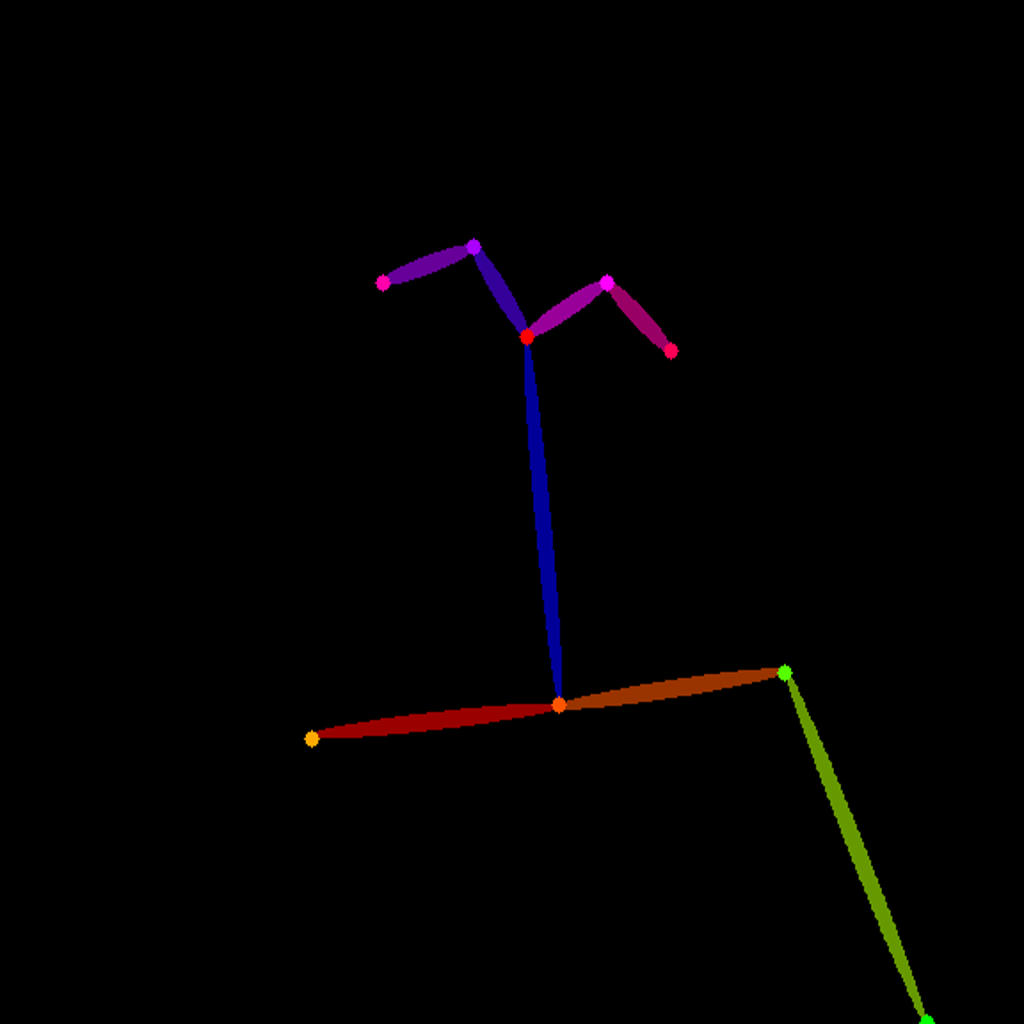

In [4]:
# pose images
pose_image = load_image("parked_domain_girl.jpg")
pose_kps = openpose(pose_image).resize((1024, 1024))
pose_kps

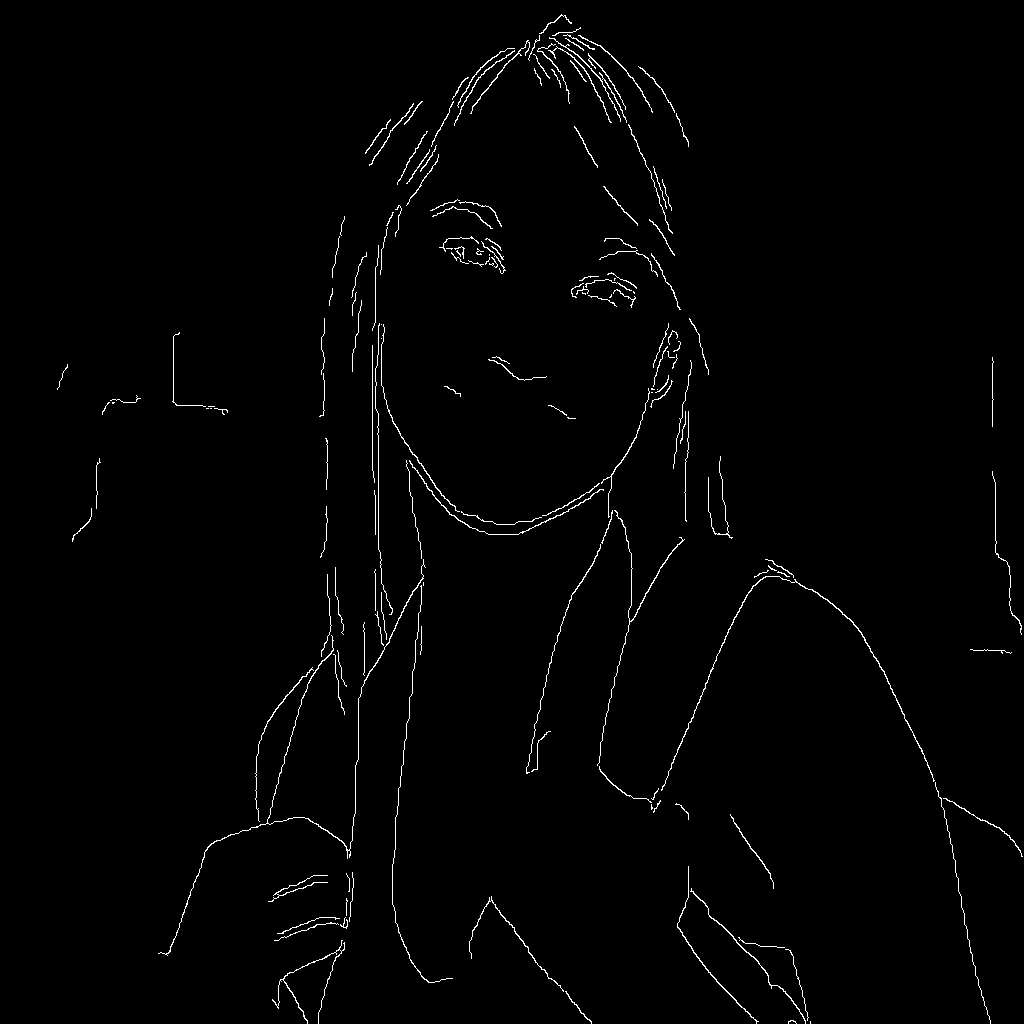

In [5]:
canny_img = get_canny_image(pose_image.resize((1024, 1024)))
canny_img

  0%|          | 0/50 [00:00<?, ?it/s]

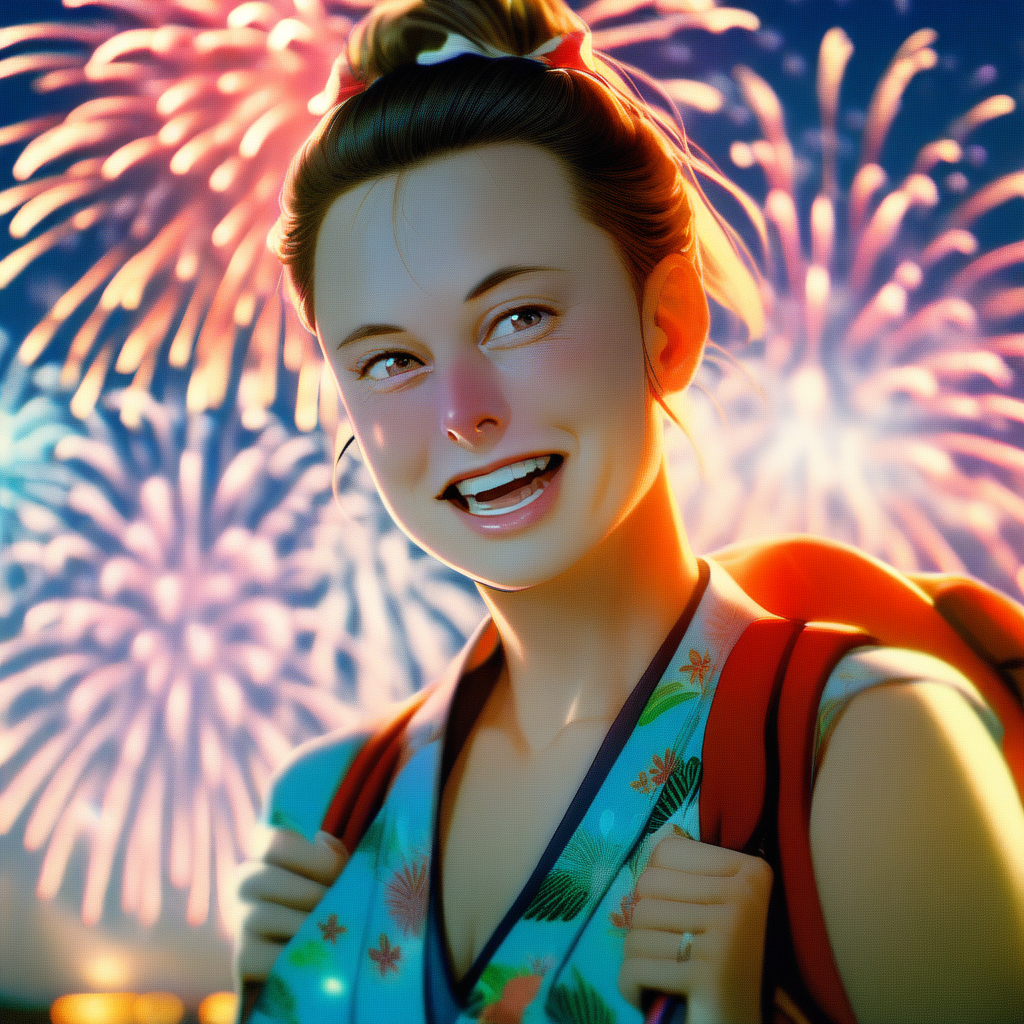

In [20]:
# prompt
prompt = "1girl, holding backpack, fireworks blooming, japanese summer, best quality"
negative_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"

# generate image
image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image_embeds=face_emb,
    image=[face_kps, pose_kps, canny_img],
    controlnet_conditioning_scale=[0.6, 0.4, 0.15],
    ip_adapter_scale=0.65,
).images[0]
image